Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Rita González Márquez

Summer term 2024

Name: Stephan Amann, Hannah Blaurock, David Kleindiek

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [1]:
# import packages here
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jupyter_black
from tqdm import tqdm

jupyter_black.load()

/home/main/miniconda3/envs/nds/lib/python3.10/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


## Context
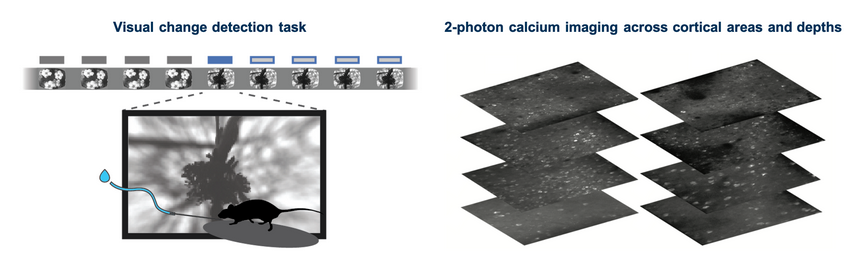

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

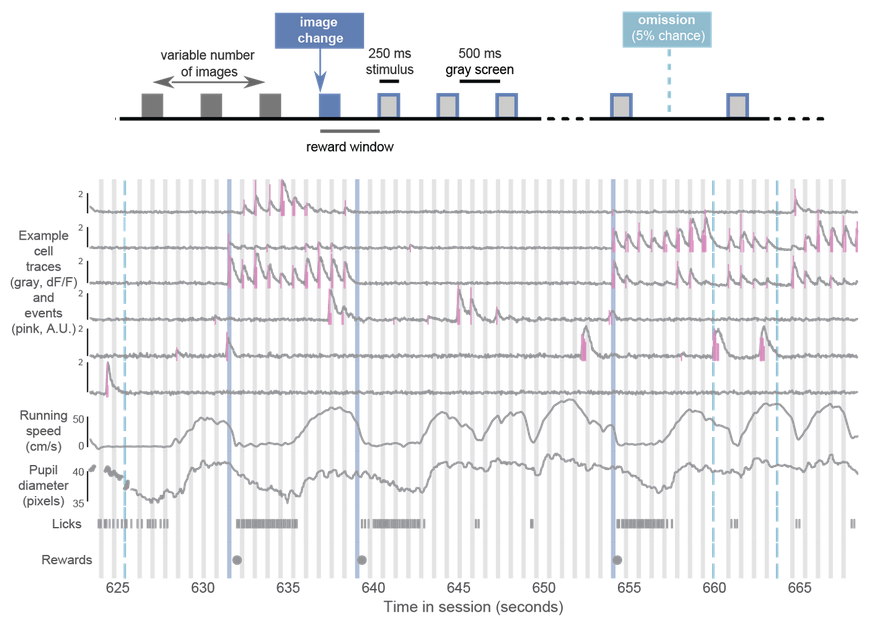

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [2]:
# load data
def load_data(path="../data"):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    print("Data keys: ", data.keys())
    array2df(
        data,
        "stim_table",
        ["temporal_frequency", "orientation", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["stimulus", "start", "end"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Data keys:  dict_keys(['t', 'dff', 'stim_table', 'roi_masks', 'max_projection', 'running_speed', 'stim_epoch_table'])
Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



# 1. Data Exploration

In [3]:
t = data["t"]
dff = data["dff"]
stim_table = data["stim_table"]
roi_masks = data["roi_masks"]
max_projection = data["max_projection"]
running_speed = np.nan_to_num(data["running_speed"][0], nan=0)
stim_epoch_table = data["stim_epoch_table"]

In [4]:
# change stim_table "start" and "end" to int
stim_table["start"] = stim_table["start"].astype(int)
stim_table["end"] = stim_table["end"].astype(int)
stim_table

,temporal_frequency,orientation,blank_sweep,start,end
0,1.0,225.0,0.0,747,807
1,2.0,180.0,0.0,837,897
2,4.0,90.0,0.0,927,987
3,1.0,270.0,0.0,1018,1077
4,4.0,135.0,0.0,1108,1168
...,...,...,...,...,...
623,4.0,315.0,0.0,114794,114854
624,2.0,45.0,0.0,114884,114944
625,4.0,180.0,0.0,114975,115034
626,4.0,270.0,0.0,115065,115125


In [5]:
stim_table[stim_table["blank_sweep"] == 1]

,temporal_frequency,orientation,blank_sweep,start,end
24,NaN,NaN,1.0,2914,2974
26,NaN,NaN,1.0,3094,3154
30,NaN,NaN,1.0,3456,3515
31,NaN,NaN,1.0,3546,3606
36,NaN,NaN,1.0,3997,4057
82,NaN,NaN,1.0,8151,8210
116,NaN,NaN,1.0,11220,11280
124,NaN,NaN,1.0,11943,12002
147,NaN,NaN,1.0,14019,14079
153,NaN,NaN,1.0,14561,14621


In [6]:
stim_epoch_table

,stimulus,start,end
0,drifting_gratings,747,18775
1,natural_movie_three,19709,37767
2,natural_movie_one,38671,47699
3,drifting_gratings,48602,66630
4,spontaneous,66780,75697
5,natural_movie_three,75698,93756
6,drifting_gratings,94659,115215


In [7]:
t[stim_table["end"][1]] - t[stim_table["start"][1]]

np.float64(1.9952300000000065)

In [8]:
# TODO insert exploration code and plots here!

In [9]:
# we checked the data and found that the difference between the time points is not constant and varies by a small amount # TODO justify!
fs = 1 / np.mean(np.diff(t))  # sampling frequency
dt = 1 / fs  # time step

print(f"Sampling frequency is {fs} Hz, Time Interval is {dt} s")

Sampling frequency is 30.070762151865303 Hz, Time Interval is 0.03325489373863341 s


# 2. Preprocessing

TODO add text here!

WE JUST USE OASIS

Todo: Conclusion?

## 2.3 Deconvolution

TODO Text

- Thresholding wird auch von https://doi.org/10.1371/journal.pcbi.1005423 durchgeführt, liefert ganz gut Ergebnisse

In [10]:
# this runs for a while. You can load the results from file in the cell below instead.
# If you want to run it, set from_file=False
from_file = False
inferred_spikes = {}
if not from_file:
    inferred_spikes = utils.oasis_inference(dff=dff, to_file=True)
else:
    inferred_spikes = utils.load_inferred_spikes("../data/inference_oasis.pkl")

for k in inferred_spikes.keys():
    print(f"Key: {k}, Shape: {inferred_spikes[k].shape}")

100%|██████████| 106/106 [00:06<00:00, 15.55it/s]


Key: spikes, Shape: (106, 115471)
Key: deconv, Shape: (106, 115471)
Key: binspikes, Shape: (106, 115471)


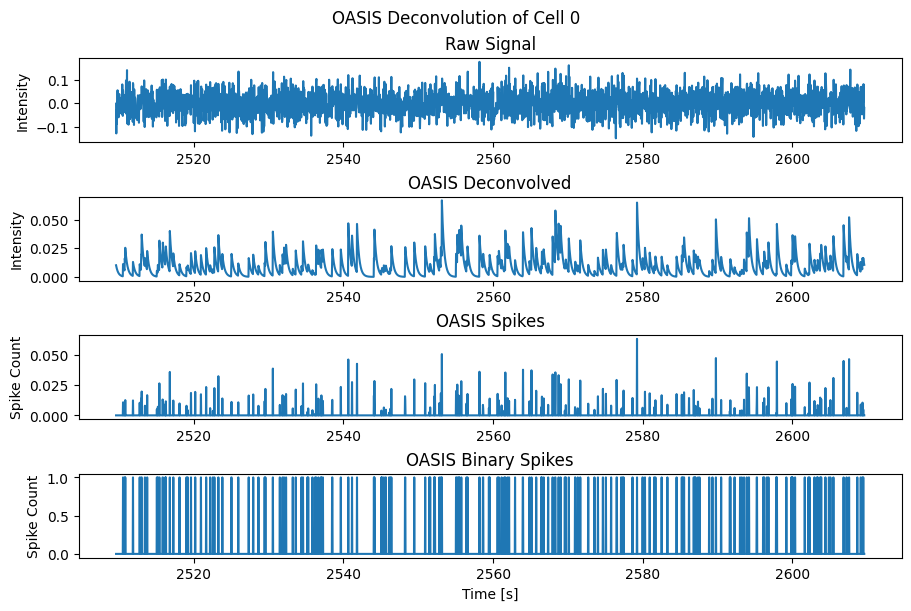

In [11]:
# plot the results for a cell
start = int(2500 * fs)  # 0
end = int(2600 * fs)  # len(t) - 1
cell_idx = 0

fig, axs = plt.subplots(4, 1, figsize=(9, 6), layout="constrained")
axs[0].plot(t[start:end], dff[cell_idx][start:end])
axs[0].set_title("Raw Signal")
axs[0].set_ylabel("Intensity")

axs[1].plot(t[start:end], inferred_spikes["deconv"][cell_idx, start:end])
axs[1].set_title("OASIS Deconvolved")
axs[1].set_ylabel("Intensity")

axs[2].plot(t[start:end], inferred_spikes["spikes"][cell_idx, start:end])
axs[2].set_title("OASIS Spikes")
axs[2].set_ylabel("Spike Count")

axs[3].plot(t[start:end], inferred_spikes["binspikes"][cell_idx, start:end])
axs[3].set_title("OASIS Binary Spikes")
axs[3].set_ylabel("Spike Count")


plt.xlabel("Time [s]")
plt.suptitle(f"OASIS Deconvolution of Cell {cell_idx}")

plt.show()

## 2.4 Intermediate Analysis

TODO Text!

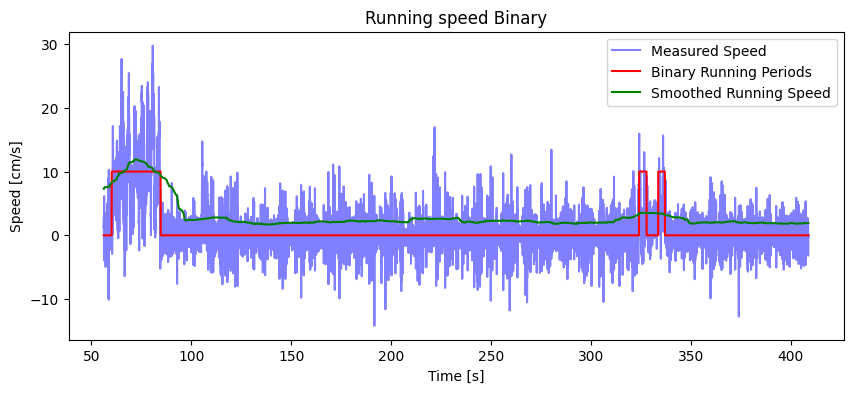

In [12]:
# we filter the running speed signal
running_periods = utils.filter_running_speed(running_speed)

# convolution und smoothing mit root mean squared error
# Window size: we apply quite heavy smoothing for better visualization --> between 500-1000 is feasible here
running_smooth = utils.window_rms(running_speed, 750)

start = 1400
end = 12000

fig, axs = plt.subplots(1, 1, figsize=(10, 4))
axs.plot(
    t[start:end],
    running_speed[start:end],
    color="blue",
    label="Measured Speed",
    alpha=0.5,
)
axs.plot(
    t[start:end],
    running_periods[start:end] * 10,
    color="red",
    label="Binary Running Periods",
)
axs.plot(
    t[start:end],
    running_smooth[start:end],
    color="green",
    label="Smoothed Running Speed",
)
axs.set_title("Running speed Binary")
axs.set_xlabel("Time [s]")
axs.set_ylabel("Speed [cm/s]")
plt.legend()
plt.show()

/home/main/miniconda3/envs/nds/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


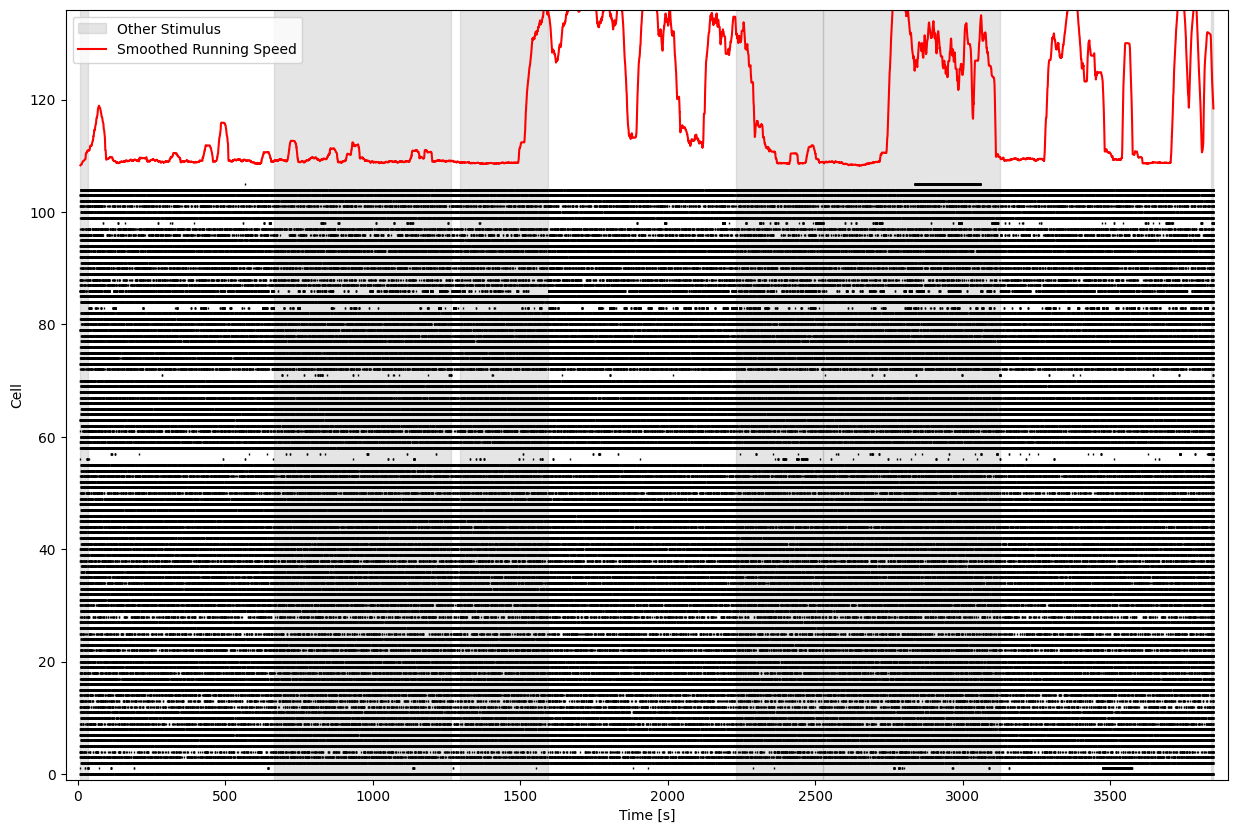

In [13]:
# plot the detected spikes per cell and running speed
# Window
start = int(fs * 0)
end = len(t) - 1  # int(fs * 3600)

show_epochs = True
show_running = True

fig, axs = plt.subplots(figsize=(15, 10))
for cellIdx in range(dff.shape[0]):
    spike_train_cell = inferred_spikes["binspikes"][cellIdx, :]
    # create binary array for spikes and no spikes in spike train
    spike_binary = np.ones_like(spike_train_cell) * -50
    spike_binary[spike_train_cell == 1] = cellIdx
    axs.plot(
        t[start:end],
        spike_binary[start:end],
        marker="|",
        linestyle="None",
        color="k",
        markersize=2,
    )

# mark the epochs where the locally sparse noise stimulus is not shown
other_stimuli = utils.get_epochs_in_range(
    stim_epoch_table, start, end
)  # TODO zeiträume rausrechnen in denen nix gezeigt wird
if show_epochs and not other_stimuli.empty:
    for i in range(other_stimuli.shape[0]):
        ep_start = other_stimuli.iloc[i]["start"]
        ep_end = other_stimuli.iloc[i]["end"]
        if i == 0:
            axs.axvspan(
                t[ep_start], t[ep_end], color="gray", alpha=0.2, label="Other Stimulus"
            )
        else:
            axs.axvspan(t[ep_start], t[ep_end], color="gray", alpha=0.2)

# # mark the running periods with a red line
# running_epochs = utils.get_epochs_in_range(
#     utils.get_running_periods_table(running_periods), start, end
# )
# running_epochs = running_epochs[running_epochs["stimulus"] == "running"]
# if show_running and not running_epochs.empty:
#     for i in range(running_epochs.shape[0]):
#         r_start = running_epochs.iloc[i]["start"]
#         r_end = running_epochs.iloc[i]["end"]
#         if i == 0:
#             axs.axvspan(
#                 t[r_start], t[r_end], color="blue", alpha=0.3, label="Running Period"
#             )
#         else:
#             axs.axvspan(t[r_start], t[r_end], color="blue", alpha=0.3)

axs.plot(
    t[start:end],
    running_smooth[start:end] + dff.shape[0] + 1,
    color="red",
    label="Smoothed Running Speed",
)

# TODO: yticks ab dff.shape[0] und legende (rot = running speed) hin
axs.set_xlim(t[start] - 50, t[end] + 50)
axs.set_ylim(-1, dff.shape[0] + 30)
axs.set_xlabel("Time [s]")
axs.set_ylabel("Cell")
# if not running_epochs.empty or not other_stimuli.empty:
#     plt.legend()
plt.legend()
plt.show()

In [14]:
# TODO running periods correlieren lassen
from scipy.stats import ttest_ind, mannwhitneyu, pearsonr
import statsmodels.stats.multitest as smm


# Function to analyze spike and running period correlation
def analyze_spike_running_correlation(spiketrains, running_period):
    n_cells, n_measurements = spiketrains.shape

    # Ensure running_period is boolean
    running_period = running_period.astype(bool)

    # Initialize lists to store results
    p_values = []

    # Iterate over each cell to perform the statistical test
    for cell in range(n_cells):
        # Get spikes for running and non-running periods
        spikes_running = spiketrains[cell, running_period]
        spikes_non_running = spiketrains[cell, ~running_period]

        # Calculate the average spike rate during running and non-running periods
        rate_running = np.mean(spikes_running)
        rate_non_running = np.mean(spikes_non_running)

        # Perform unpaired statistical test
        if np.var(spikes_running) == 0 or np.var(spikes_non_running) == 0:
            # If there's no variation, set p-value to 1.0
            p_value = 1.0
        else:
            # Use independent t-test or Mann-Whitney U test
            t_stat, p_value = ttest_ind(
                spikes_running, spikes_non_running, equal_var=False
            )

        p_values.append(p_value)

    # Apply multiple comparisons correction (Bonferroni)
    corrected_p_values = smm.multipletests(p_values, method="bonferroni")[1]

    # Identify significant cells
    significant_cells = np.where(corrected_p_values < 0.05)[0]

    return significant_cells, corrected_p_values


assert running_periods.shape[0] == inferred_spikes["binspikes"].shape[1]
analyze_spike_running_correlation(inferred_spikes["binspikes"], running_periods)

(array([  0,   1,   3,   5,   7,   8,   9,  10,  11,  12,  13,  15,  18,
         19,  20,  21,  24,  25,  26,  29,  30,  32,  34,  40,  47,  48,
         50,  54,  58,  62,  69,  72,  74,  76,  77,  78,  80,  82,  83,
         84,  86,  87,  88,  93,  95,  96,  98,  99, 101, 102, 103, 104,
        105]),
 array([4.61165952e-002, 1.23831932e-002, 8.15978859e-001, 7.21932049e-007,
        1.00000000e+000, 1.58000039e-007, 8.42543331e-001, 1.18832361e-002,
        8.55758566e-046, 3.59521274e-009, 2.24360859e-015, 1.78344955e-007,
        2.95892615e-006, 2.96593783e-004, 1.00000000e+000, 1.76877425e-026,
        1.00000000e+000, 1.00000000e+000, 2.36879670e-003, 8.46233484e-003,
        2.32154851e-004, 7.80612814e-010, 6.37526435e-001, 1.00000000e+000,
        5.27305850e-163, 1.10119824e-002, 2.10359060e-104, 1.00000000e+000,
        1.00000000e+000, 4.87314690e-003, 5.93162084e-014, 1.00000000e+000,
        8.78796484e-028, 7.94136899e-002, 2.30637965e-002, 1.00000000e+000,
        7

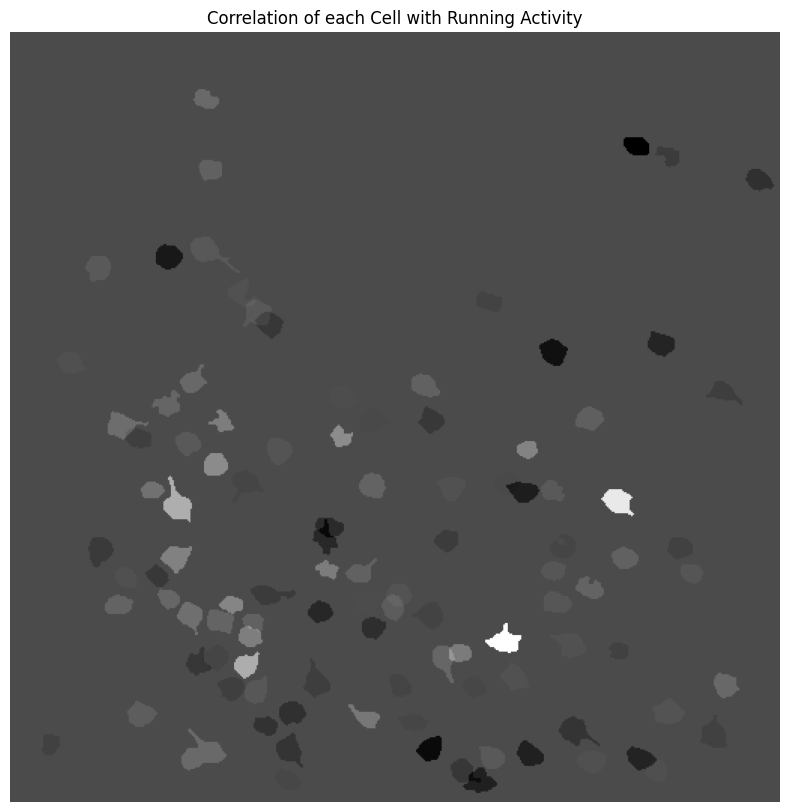

In [15]:
roi_masks = data["roi_masks"].copy()
roi_masks_corr = np.zeros_like(roi_masks, dtype=np.float64)
for cell in range(roi_masks.shape[0]):
    corr, p = pearsonr(inferred_spikes["binspikes"][cell], running_speed)
    roi_masks_corr[cell, :, :] = np.where(
        roi_masks[cell, :, :].astype(np.float64) < 1, roi_masks[cell, :, :], corr
    )

roi_masks_sum = np.sum(roi_masks, axis=0)
roi_masks_sum = roi_masks_sum / np.max(roi_masks_sum)

roi_masks_corr_sum = np.sum(roi_masks_corr, axis=0)
roi_masks_corr_sum = roi_masks_corr_sum / np.max(roi_masks_corr_sum)


fig, axs = plt.subplots(1, 1, figsize=(10, 10))
# axs.imshow(roi_masks_sum, cmap="gray", alpha=0.5)
axs.imshow(
    roi_masks_corr_sum, cmap="gray"
)  # TODO diverging color bar mit limits einfügen... Stephan macht das noch

axs.set_title("Correlation of each Cell with Running Activity")
axs.axis("off")
plt.show()

## Question

**Is there spatial structure in the preferred orientation/direction/temporal frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.

In [16]:
def vonMises(θ: np.ndarray, α: float, κ: float, ν: float, ϕ: float) -> np.ndarray:
    """Evaluate the parametric von Mises tuning curve with parameters p at locations theta.

    Parameters
    ----------

    θ: np.array, shape=(N, )
        Locations. The input unit is degree.

    α, κ, ν, ϕ : float
        Function parameters

    Return
    ------
    f: np.array, shape=(N, )
        Tuning curve.
    """

    # Convert theta to radians
    theta_rad = np.deg2rad(θ)
    phi_rad = np.deg2rad(ϕ)

    f = np.exp(
        α
        + κ * (np.cos(2 * (theta_rad - phi_rad)) - 1)
        + ν * (np.cos(theta_rad - phi_rad) - 1)
    )
    return f

In [41]:
from scipy.optimize import curve_fit


def fitTemporalTuningCurve(
    inferred_spikes: np.ndarray,
    stim_table=pd.DataFrame(),
):
    """Fit a von Mises tuning curve to the spike counts in count with direction dir using a least-squares fit.
    Parameters
    ----------
    inferred_spikes: np.array, shape=(n_neurons, n_timepoints)

    stim_table: pd.DataFrame
        DataFrame containing the stimulus information

    neuron: int, default=0

    Return
    ------
    fitted_curves: np.array, shape=(n_temporal_frequencies, n_directions)
        Fitted tuning curves for each temporal frequency

    mean_spike_counts: np.array, shape=(n_directions,)
        Mean spike counts per direction

    std_spike_counts: np.array, shape=(n_directions,)
        Standard deviation of spike counts per direction
    """
    result = {}

    starts = stim_table["start"].astype(int).to_numpy()
    ends = stim_table["end"].astype(int).to_numpy()

    dirs = stim_table["orientation"].dropna()
    unique_directions = np.unique(dirs).astype(int)
    unique_directions.sort()

    temporal_frequencies = stim_table["temporal_frequency"].dropna()
    unique_temporal_frequencies = np.unique(temporal_frequencies).astype(int)
    unique_temporal_frequencies.sort()

    for neuron in tqdm(range(inferred_spikes["binspikes"].shape[0])):
        # Vectorized calculation of spike counts
        spike_counts = np.array(
            [
                np.sum(inferred_spikes["binspikes"][neuron, start:end])
                for start, end in zip(starts, ends)
            ]
        )
        spike_counts = spike_counts[stim_table["orientation"].dropna().index]
        initial_guess = [np.mean(spike_counts), 1, 1, np.median(dirs)]

        curves_temporal_frequencies = np.zeros(
            (len(unique_temporal_frequencies), len(initial_guess))
        )
        fitted_curves = np.zeros(
            (len(unique_temporal_frequencies), len(unique_directions))
        )
        mean_spike_counts = np.array(
            [np.mean(spike_counts[dirs == d]) for d in unique_directions]
        )
        std_spike_counts = np.array(
            [np.std(spike_counts[dirs == d]) for d in unique_directions]
        )

        for i, temporal_frequency in enumerate(unique_temporal_frequencies):
            # Perform the non-linear least squares fit
            bounds = (
                [-np.inf, -np.inf, -np.inf, -np.inf],
                [np.inf, np.inf, np.inf, 360],
            )
            popt, _ = curve_fit(
                vonMises,
                dirs[temporal_frequencies == temporal_frequency],
                spike_counts[temporal_frequencies == temporal_frequency],
                p0=initial_guess,
                bounds=bounds,
                maxfev=5000,
            )
            curves_temporal_frequencies[i, :] = popt

            fitted_curves[i, :] = vonMises(unique_directions, *popt)

        result[neuron] = {
            "fitted_curves": fitted_curves,
            "mean_spike_counts": mean_spike_counts,
            "std_spike_counts": std_spike_counts,
        }
    return result


def getMaxOfTemporalTuningCurves(
    tuning_curve_fit: dict,
    stim_table,
):
    unique_dirs = np.unique(stim_table["orientation"].dropna())
    unique_dirs.sort()
    unique_temps = np.unique(stim_table["temporal_frequency"].dropna())
    unique_temps.sort()
    results = {}
    for neuron in tuning_curve_fit.keys():
        fitted_curves = tuning_curve_fit[neuron]["fitted_curves"]
        max_curve_idx_for_all_directions = np.argmax(fitted_curves, axis=0)
        max_direction_idx = np.argmax(np.max(fitted_curves, axis=0))

        # print(
        #     max_curve_idx_for_all_directions,
        #     np.max(fitted_curves, axis=0),
        #     max_direction_idx,
        # )
        # print(
        #     tuning_curve_fit[neuron]["fitted_curves"][
        #         max_curve_idx_for_all_directions[max_direction_idx]
        #     ]
        # )

        # remove the maximum direction from the list and get the second maximum
        fitted_curves[
            max_curve_idx_for_all_directions[max_direction_idx], max_direction_idx
        ] = 0
        # print(
        #     tuning_curve_fit[neuron]["fitted_curves"][
        #         max_curve_idx_for_all_directions[max_direction_idx]
        #     ]
        # )
        max_direction_idx2 = np.argmax(
            tuning_curve_fit[neuron]["fitted_curves"][
                max_curve_idx_for_all_directions[max_direction_idx]
            ]
        )

        is_orientational = (
            1
            if (unique_dirs[max_direction_idx] + 180) % 360
            == unique_dirs[max_direction_idx2]
            else 0
        )
        results[neuron] = {
            "max_direction": unique_dirs[max_direction_idx],
            "max_direction2": unique_dirs[max_direction_idx2],
            "is_orientationnal": is_orientational,
        }
        break
    return results


def plotTemporalTuningCurve(
    neuron: int,
    tuning_curve_fit: dict,
    stim_table,
):
    fitted_curves = tuning_curve_fit[neuron]["fitted_curves"]
    mean_spike_counts = tuning_curve_fit[neuron]["mean_spike_counts"]
    std_counts = tuning_curve_fit[neuron]["std_spike_counts"]

    unique_temps = np.unique(stim_table["temporal_frequency"].dropna())
    unique_temps.sort()
    unique_dirs = np.unique(stim_table["orientation"].dropna())
    unique_dirs.sort()

    fig, ax = plt.subplots(figsize=(7, 5))
    # Plot average spike count per direction
    ax.plot(
        unique_dirs,
        mean_spike_counts,
        label="Mean Spike Count",
        color="orange",
        linewidth=2,
        alpha=0.7,
    )
    # Plot the standard deviation
    ax.fill_between(
        unique_dirs,
        mean_spike_counts - std_counts,
        mean_spike_counts + std_counts,
        alpha=0.1,
        color="orange",
    )
    # Plot fitted tuning curves for each temporal frequency
    [
        ax.plot(
            unique_dirs,
            fitted_curves[i, :],
            label=f"T {unique_temps[i]} [Hz]",
            linestyle="--",
        )
        for i in range(len(unique_temps))
    ]
    # get the two directions with the maximum at all fitted curves
    max_curve_idx_for_all_directions = np.argmax(fitted_curves, axis=0)
    max_direction_idx = np.argmax(np.max(fitted_curves, axis=0))
    ax.plot(
        unique_dirs[max_direction_idx],
        fitted_curves[
            max_curve_idx_for_all_directions[max_direction_idx], max_direction_idx
        ],
        "ro",
    )
    # remove the maximum direction from the list and get the second maximum
    fitted_curves[max_curve_idx_for_all_directions[max_direction_idx]][
        max_direction_idx
    ] = 0
    max_direction_idx = np.argmax(
        np.max(fitted_curves[max_curve_idx_for_all_directions], axis=0)
    )
    ax.plot(
        unique_dirs[max_direction_idx],
        fitted_curves[
            max_curve_idx_for_all_directions[max_direction_idx], max_direction_idx
        ],
        "ro",
    )

    ax.set_xticks(np.arange(0, 361, 45))
    ax.set_xlim(0, 360)
    ax.set_xlabel("Direction [deg]")
    ax.set_ylabel("Mean Spike Count")
    ax.set_title("Tuning Curve Fit of Neuron {}".format(neuron))
    ax.legend()
    plt.show()

In [36]:
fitted_tuning_curves = fitTemporalTuningCurve(
    inferred_spikes,
    stim_table,
)
# DAVID
# The dictionary contains the fitted tuning curves, mean spike counts and standard deviations for each neuron
# access like this: fitted_tuning_curves[neuron]["fitted_curves"], fitted_tuning_curves[neuron]["mean_spike_counts"], fitted_tuning_curves[neuron]["std_spike_counts"]
# fitted_tuning_curves[0]["fitted_curves"].shape # (n_temporal_frequencies, n_directions)

100%|██████████| 106/106 [00:14<00:00,  7.25it/s]


In [42]:
max_of_temporal_tuning_curve = getMaxOfTemporalTuningCurves(
    fitted_tuning_curves.copy(), stim_table
)
max_of_temporal_tuning_curve[0]

[0 3 1 1 0 0 0 3] [4.04478773 4.50768705 4.94864645 4.49064751 4.26235496 4.86616118
 5.02616663 4.57085409] 6
[4.04478773 4.04220244 4.07426991 4.00699635 4.26235496 4.86616118
 5.02616663 4.4792833 ]
[4.04478773 4.04220244 4.07426991 4.00699635 4.26235496 4.86616118
 0.         4.4792833 ]


{'max_direction': np.float64(270.0),
 'max_direction2': np.float64(225.0),
 'is_orientationnal': 0}

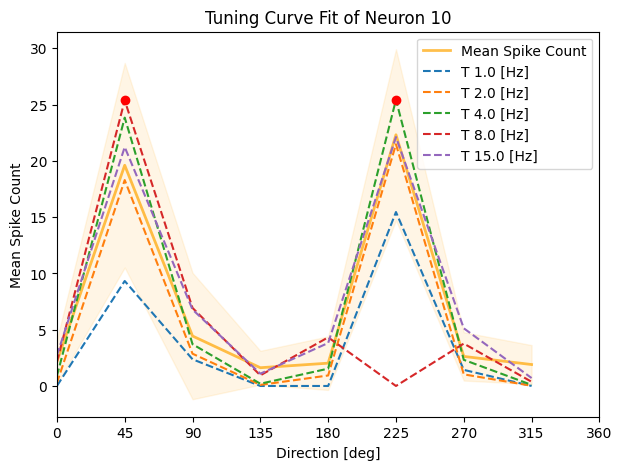

In [101]:
cellIdx = 10
plotTemporalTuningCurve(
    cellIdx,
    fitted_tuning_curves,
    stim_table,
)

In [18]:
def testTuningFunction(
    inferred_spikes: np.ndarray,
    stim_table=pd.DataFrame(),
    psi: int = 1,
    niters: int = 1000,
    random_seed: int = 2046,
):
    starts = stim_table["start"].astype(int).to_numpy()
    ends = stim_table["end"].astype(int).to_numpy()

    dirs = stim_table["orientation"].dropna()
    unique_directions = np.unique(dirs).astype(int)
    unique_directions.sort()
    theta_k = np.deg2rad(np.unique(unique_directions))

    temporal_frequencies = stim_table["temporal_frequency"].dropna()
    unique_temporal_frequencies = np.unique(temporal_frequencies).astype(int)
    unique_temporal_frequencies.sort()

    result = {}
    for neuron in tqdm(range(inferred_spikes["binspikes"].shape[0])):
        result[neuron] = {}
        # Vectorized calculation of spike counts
        spike_counts = np.array(
            [
                np.sum(inferred_spikes["binspikes"][neuron, start:end])
                for start, end in zip(starts, ends)
            ]
        )
        spike_counts = spike_counts[stim_table["orientation"].dropna().index]

        for i, temporal_frequency in enumerate(
            np.concatenate((unique_temporal_frequencies, [-1]))
        ):
            m_k = np.array(
                [
                    np.mean(
                        spike_counts[temporal_frequencies == temporal_frequency][
                            dirs[temporal_frequencies == temporal_frequency] == d
                        ]
                        if temporal_frequency != -1
                        else spike_counts[dirs == d]
                    )
                    for d in unique_directions
                ]
            )
            v_k = np.exp(psi * 1j * theta_k)
            q = np.abs(np.dot(m_k, v_k))

            rng = np.random.default_rng(random_seed)
            qdistr = np.zeros(niters)

            for i in range(niters):
                shuffled_counts = rng.permutation(spike_counts)
                shuffled_m_k = np.array(
                    [np.mean(shuffled_counts[dirs == d]) for d in unique_directions]
                )
                qdistr[i] = np.abs(np.dot(shuffled_m_k, v_k))

            p = np.sum(qdistr >= q) / niters
            result[neuron][temporal_frequency] = {
                "p": p,
                "q": q,
                "qdistr": qdistr,
            }
    return result


def plotTestTuningFunction(
    neuron: int,
    test_results: dict,
    stim_table,
):
    for temporal_frequency, result in test_results[neuron].items():
        q = result["q"]
        qdistr = result["qdistr"]

        fig, ax = plt.subplots(figsize=(7, 4))
        ax.hist(qdistr, bins=30, color="skyblue", edgecolor="black", alpha=0.7)
        ax.axvline(q, color="red", linestyle="--", label=f"Observed |q| = {q:.2f}")
        ax.set_xlabel("|q| Values")
        ax.set_ylabel("Frequency")
        ax.set_title(
            f"Permutation Test Direction Tuning of Neuron {neuron} of Temp {temporal_frequency}"
        )
        ax.set_xlim(left=0)
        ax.legend()
        plt.show()

In [19]:
testTuningFunctionResultsOr = testTuningFunction(inferred_spikes, stim_table, psi=2)
testTuningFunctionResultsDir = testTuningFunction(inferred_spikes, stim_table, psi=1)
# DAVID
# Return a dictionary with the p-values, q-values and qdistr for each neuron and temporal frequency
# Access like this: testTuningFunctionResults[neuron][temporal_frequency]["p"], testTuningFunctionResults[neuron][temporal_frequency]["q"], testTuningFunctionResults[neuron][temporal_frequency]["qdistr"]
# temporal_frequency = -1 means all directions
testTuningFunctionResultsOr[0].keys()

 34%|███▍      | 36/106 [00:58<01:52,  1.61s/it]


KeyboardInterrupt: 

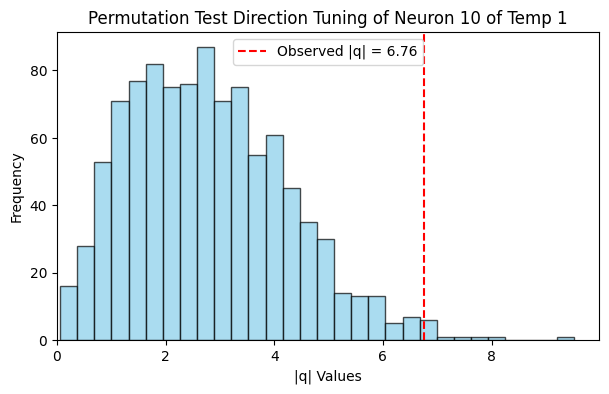

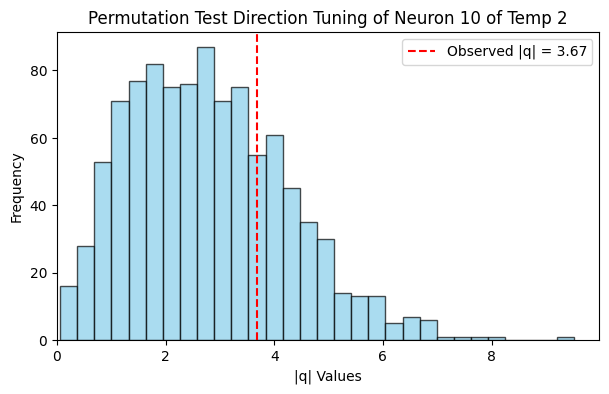

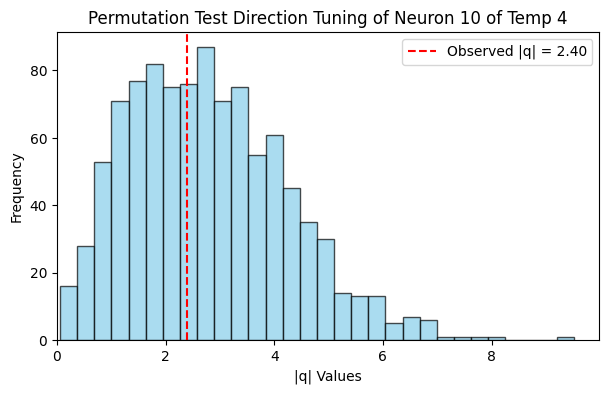

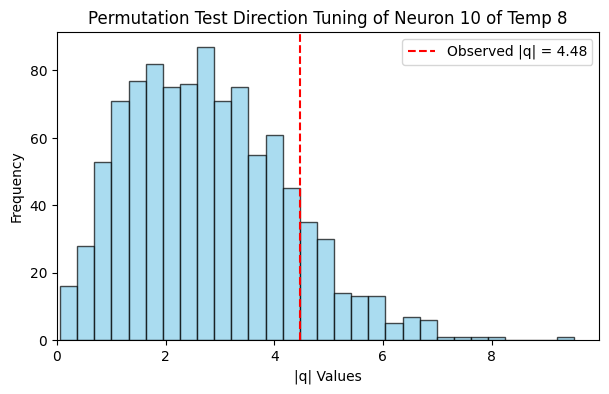

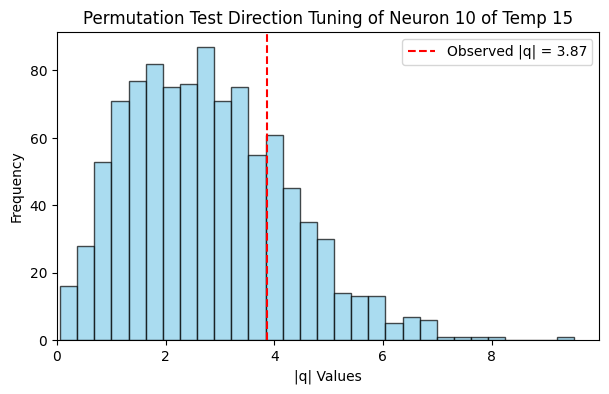

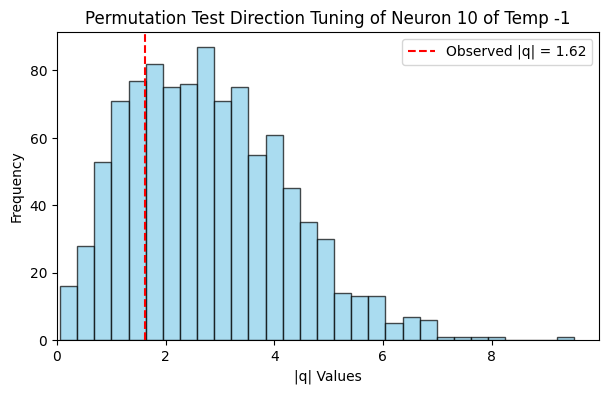

In [104]:
plotTestTuningFunction(
    10,
    testTuningFunctionResultsDir,
    stim_table,
)

Todo:

- plot oben zum laufen kriegen
- peri stimulius time plots aus CL4
- Unterschied direction / orientation? Wir haben orientation gegeben, in CL4 war direction of motion gegeben? 
--> muss man die tuning function anpassen? Wenn ja wie? 

*Antwort:* Orientation = Ausrichtung des Musters (statisch), Direction = Bewegungsrichtung des Musters. --> Tuning function muss nicht angepasst werden. 

- spatial structure: preferred orientation (max der tuning curve) einfärben (wenn signifikant?) = Direction?

- überlegen wie spatial frequency da rein kommt und warum temporal frequency gegeben wurde 

*Idee:* Für jede temporal frequency separat rechnen. Was spatial frequency sein soll kp, ich vermute die wellenlänge des stimulus. **Vorschlag** wir gehen einfach erstmal davon aus, dass temporal = spatial freq sein soll, da wir nix wissen über wellenlänge des stimulus oder geschwindigkeit.

- Complex / simple cells 


**Weitere Gedanken:**
- plane sweep zeiten als referenz?
- was ist mit den irrelevanten zeiträumen?
- shift der spikes wieder berücksichtigen?
- Histogram binning?
- Wann benutzen wir jetzt spikes und wann binspikes?

In [105]:
# asses temporal frequency:
def get_data(stim_table, spikes, neuron):
    spike_count = np.zeros(len(stim_table["start"]))
    for i in range(len(stim_table)):
        start = stim_table["start"][i].astype(int)
        end = stim_table["end"][i].astype(int)
        spike_count[i] = np.sum(spikes["binspikes"][neuron, start:end])

    return spike_count


spike_count = get_data(stim_table, inferred_spikes, neuron=0)

In [106]:
unique_dirs = np.unique(stim_table["temporal_frequency"].dropna())
neurons = inferred_spikes["binspikes"].shape[0]
temporal_tunings = np.zeros((2, neurons, len(unique_dirs)))
for neuron in range(neurons):
    spike_count = get_data(stim_table, inferred_spikes, neuron=neuron)
    spike_count = spike_count[stim_table["temporal_frequency"].dropna().index]
    temporal_tuning_mean = np.array(
        [
            np.mean(spike_count[stim_table["temporal_frequency"].dropna() == d])
            for d in unique_dirs
        ]
    )
    temporal_tuning_sd = np.array(
        [
            np.std(spike_count[stim_table["temporal_frequency"].dropna() == d])
            for d in unique_dirs
        ]
    )
    temporal_tunings[0, neuron, :] = temporal_tuning_mean
    temporal_tunings[1, neuron, :] = temporal_tuning_sd

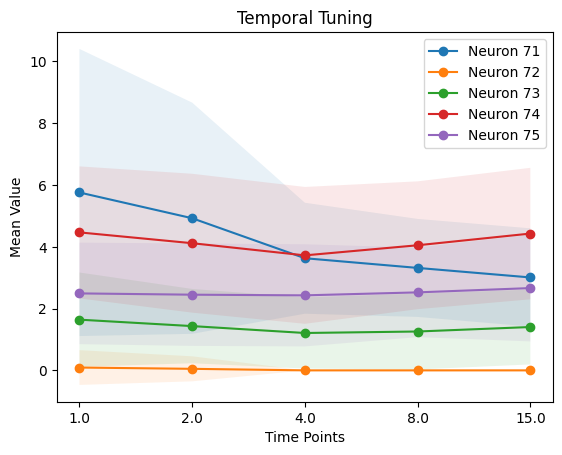

In [107]:
# TODO: Den plot hier interakitv machen? Für alle Neurone?
x = np.arange(temporal_tunings.shape[2])

for neuron_index in range(70, 75):
    temporal_tuning_mean = temporal_tunings[0, neuron_index, :]
    temporal_tuning_sd = temporal_tunings[1, neuron_index, :]
    # Plot mean line
    plt.plot(x, temporal_tuning_mean, marker="o", label=f"Neuron {neuron_index + 1}")

    # Plot shaded area for SD
    plt.fill_between(
        x,
        temporal_tuning_mean - temporal_tuning_sd,
        temporal_tuning_mean + temporal_tuning_sd,
        alpha=0.1,
    )  # Adjust alpha for transparency

# Add titles and labels
plt.title("Temporal Tuning")
plt.xlabel("Time Points")
plt.ylabel("Mean Value")

# Set the custom x-tick labels
plt.xticks(ticks=x, labels=unique_dirs)

# Add a legend
plt.legend()

## Complex vs Simple Cells:

Dividing Simples Cells and Complex Cells by the f1/f0 ratio is a well known procedure, first noted by Hubel and Wiesel (1962; Journal of Physiology, London, 160, 106–154). Because it has been verifyed many times we use the same ratio to classify simple and complex cells. 


Paper sagt: https://doi.org/10.1016/j.visres.2012.09.004
F0 (or mean activity, in spikes/s) values reported here are the
firing rates averaged over the time of stimulus presentation in sin-
gle trial or, depending on the test, averaged over all trials with gi-
ven stimulus parameters. The F1 values reported here are the
magnitudes of the first component (at stimulus temporal fre-
quency) of the frequency spectra. In the case of recordings from
subcortical structures, where visual stimulation lasted for 1 s only
data obtained during stimulation with gratings drifting at temporal
frequencies above 1 Hz were taken into account.

In [195]:
from scipy.fft import fft

stimulus_frequency = 0.5  # 1 stimulus every 2s
neurons = inferred_spikes["binspikes"].shape[0]
spike_count = np.zeros((neurons, stim_table["orientation"].shape[0]))
p_direction = np.zeros(neurons)
f1_comp = np.zeros(neurons)
for neuron in range(neurons):
    counts = get_data(stim_table, inferred_spikes, neuron=neuron)
    spike_count[neuron, :] = counts
    # Compute FFT of the spike counts
    fft_result = fft(counts)
    freqs = np.fft.fftfreq(len(counts), d=(1.0 / stimulus_frequency))
    # Magnitude of DC component
    f0 = np.mean(counts)
    # Find the index of the frequency closest to the stimulus frequency
    f1_index = np.argmin(
        np.abs(
            freqs - stimulus_frequency
        )  # find index of the frequency that is closest to stimulus frequency
    )  # fundamental frequency, f1 is the LOWEST POSSIBLE frequency of vibration in the system.
    #  The F1 values reported here are the magnitudes of the first component (at stimulus temporal frequency) of the frequency spectra
    # Compute the magnitude (amplitude) of the first harmonic component (F1)
    f1 = 2.0 / len(counts) * np.abs(fft_result[f1_index])
    f1_comp[neuron] = f1 / f0

C:\Users\Hannah Blaurock\AppData\Local\Temp\ipykernel_15964\4081585994.py:25: RuntimeWarning: invalid value encountered in double_scalars
  f1_comp[neuron] = f1 / f0


In [229]:
# Initialize an empty list to collect rows
rows = []

p_tresh = 0.01

# Iterate through each neuron and its p-values
for neuron, temporal_resolutions in testTuningFunctionResults.items():
    # Create a row with the neuron index and its p-values
    row = {"Neuron": neuron}
    for resolution, values in temporal_resolutions.items():
        row["first_harmonic"] = values[
            "q"
        ]  # Extract the q value (only with dir bc we look at first harmonic there)
        row[resolution] = 1 if values["p"] <= p_tresh else 0  # Extract the p value
    rows.append(row)

# Create DataFrame from rows
df = pd.DataFrame(rows)

# Set the Neuron column as the index
df.set_index("Neuron", inplace=True)

In [230]:
df["f1_f0"] = df["first_harmonic"] / np.mean(spike_count, axis=1)
df["complex"] = [1 if df["f1_f0"][neuron] > 1 else 0 for neuron in range(len(df))]
# Convert the dictionary to a DataFrame
max_df = pd.DataFrame.from_dict(max_of_temporal_tuning_curve, orient="index")

# Concatenate the new DataFrame with the existing one
df = pd.concat([df, max_df], axis=1)

In [231]:
df

,first_harmonic,1,2,4,8,15,-1,f1_f0,complex,max_direction,max_direction2,is_orientationnal
0,0.449902,1,1,0,1,0,0,0.105899,0,90.0,0.0,0
1,1.191632,0,0,0,1,1,0,0.612895,0,45.0,0.0,0
2,0.748671,1,1,0,1,0,0,0.221881,0,0.0,0.0,0
3,0.700572,1,1,0,1,1,0,0.512773,0,45.0,0.0,0
4,0.446955,0,1,0,1,1,0,0.632180,0,135.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
101,0.463943,0,1,1,0,1,0,0.392663,0,45.0,0.0,0
102,2.282478,1,1,0,1,1,1,0.595512,0,45.0,0.0,0
103,1.602087,1,1,1,1,0,0,0.406017,0,180.0,0.0,1
104,0.388397,0,1,1,1,0,0,0.160048,0,315.0,0.0,0


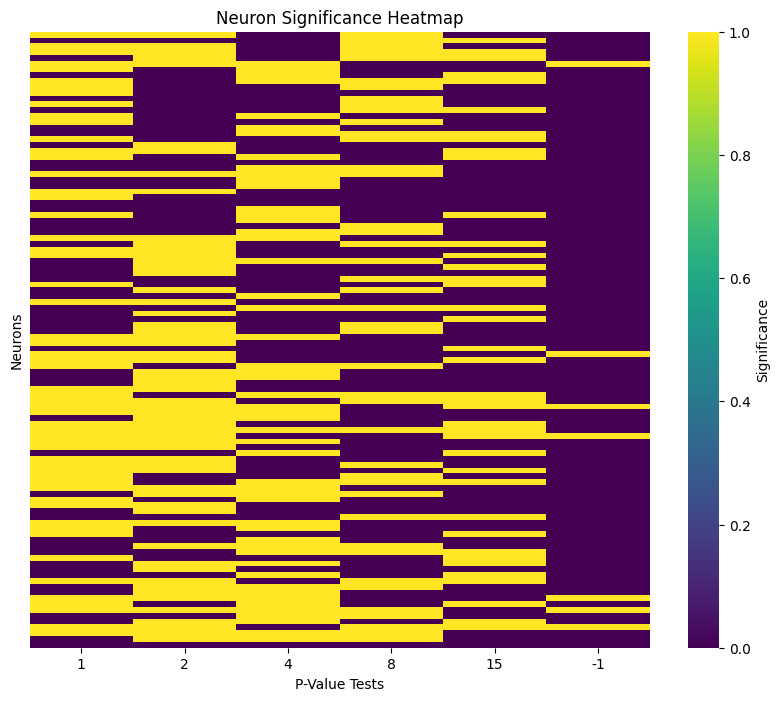

In [234]:
import seaborn as sns

keys = ["1", "2", "4", "8", "15", "-1"]

plt.figure(figsize=(10, 8))
sns.heatmap(
    df.iloc[:, 1:7],
    cmap="viridis",
    cbar_kws={"label": "Significance"},
    yticklabels=False,
)
plt.xlabel("P-Value Tests")
plt.ylabel("Neurons")
plt.title("Neuron Significance Heatmap")
plt.show()